# Two-level system with time dependent driving treated with HEOM

Considering an Hamiltonian of the form
$$H= \frac{\hbar \omega_0}  2 \sigma_z + \frac\Delta2\sigma_x + \frac{\hbar\Omega}2 [\sigma_x \cos(\omega t)]+ \sigma_x \otimes B + H_{E} $$
with parameters
- $\omega_0=1$: wlog fix $\omega_0$ and only vary the other parameters
- $\Omega$: Rabi frequency.
- $\omega$: driving frequency, resonant for $\Omega/\omega = z_k$ a zero of the Bessel $J_0$.

The coupling with the environment is given by
$$B=\sum_k g_k (a_k + a_k^\dagger)$$
and the environment has a spectral density
$$J(\omega)= \frac{2\lambda\gamma\omega}{\omega^2+\gamma^2}.$$
Environmental parameters:
- $\lambda$: coupling strength
- $\gamma$: cutoff frequency

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import *
from qutip.solver.heom import DrudeLorentzPadeBath, HEOMSolver

# Max and min of Q and S
_min_Q = 0.
_max_Q = 1. / (2. * np.pi)
_min_S = -1. / (2. * np.pi)
_max_S = 1. / (2. * np.pi)

# Default system parameters
_omega0 = 1.
_Delta = 0.
_Omega = 60
_omega = _Omega / 2.4048 # resonant driving
_domega = 10.
_tf = 30.
_Ntimesteps = 1000

# Default bath parameters + HEOM
_gamma = .5 # cutoff
_lam = 1.0 # coupling
_T = 0.5
_Nk = 2
_max_depth_HEOM = 5
_nsteps_HEOM = 15000

# Plotting params
_fontsize = 14
col_omega_m = 'red'
s_omega_m = ':'
col_omega = 'blue'
col_omega_p = 'darkgreen'
s_omega_p = '--'

# Initial state
_psi0 = (0.3 * basis(2, 0) + 0.7 * basis(2, 1)).unit()

def evolve (omega0 = _omega0, Delta = _Delta, omega = _omega, Omega = _Omega, tf = _tf, Ntimesteps = _Ntimesteps, psi0 = _psi0, gamma = _gamma, lam = _lam, T = _T, Nk = _Nk, max_depth_HEOM = _max_depth_HEOM, nsteps_HEOM = _nsteps_HEOM):
    """
    Evolves the system using HEOM with the given parameters, all can be optional

    Returns:
        result: rho(t) for the given Omega
        result_ponant: rho(t) for Omega resonant
        time: list of time points
        params: dictionary with the parameters used
    """
    Q = sigmax()
    params = {
        "omega0": omega0,
        "Delta": Delta,
        "omega": omega,
        "Omega": Omega,
        "tf": tf,
        "Ntimesteps": Ntimesteps,
        "gamma": gamma,
        "lam": lam,
        "T": T,
        "Nk": Nk}

    # Hamiltonian
    H0 = .5 * omega0 * sigmaz() + .5 * Delta * sigmax()
    def drive_x (t): return .5 * Omega * np.cos(omega * t)
    Htot = QobjEvo([H0, [sigmax(), drive_x]])

    # Initial state
    rho = psi0 * psi0.dag()

    # Bath
    bath = DrudeLorentzPadeBath(Q, lam, gamma, T, Nk)
    options_HEOM = {"nsteps": nsteps_HEOM, "progress_bar": ''}
    solver = HEOMSolver(Htot, bath, max_depth=max_depth_HEOM, options=options_HEOM)

    # Evolve
    time = np.linspace(0, tf, Ntimesteps)
    result = solver.run(rho, time)
    return result.states, params

def Q_func (theta, phi, rho):
        v = np.array([[np.cos(theta / 2)], [np.exp(1j * phi) * np.sin(theta / 2)]])
        return (1 / (2 * np.pi)) * np.real(np.vdot(v, rho.full() @ v))

## Fig 1
Trajectories on Bloch sphere

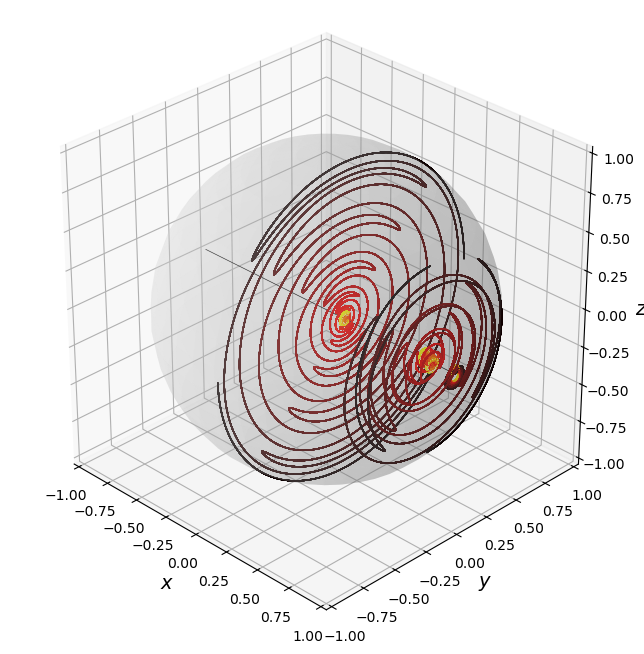

In [5]:
from matplotlib import cm
_OmegaPlotsBloch = 60
_omegaPlotsBloch = _Omega / 2.4048
_tfPlotsBloch = _tf/10

rho1, params1 = evolve(psi0=(basis(2,1)+basis(2,0)).unit(), omega=_omegaPlotsBloch, Omega=_OmegaPlotsBloch, tf=_tfPlotsBloch, nsteps_HEOM=1000*_nsteps_HEOM, Ntimesteps=1000*_Ntimesteps)
rho2, params2 = evolve(psi0=(basis(2,1)+2.*basis(2,0)).unit(), omega=_omegaPlotsBloch, Omega=_OmegaPlotsBloch, tf=_tfPlotsBloch, nsteps_HEOM=1000*_nsteps_HEOM, Ntimesteps=1000*_Ntimesteps)
rho3, params3 = evolve(psi0=(2.*basis(2,1)+basis(2,0)).unit(), omega=_omegaPlotsBloch, Omega=_OmegaPlotsBloch, tf=_tfPlotsBloch, nsteps_HEOM=1000*_nsteps_HEOM, Ntimesteps=1000*_Ntimesteps)
rho4, params4 = evolve(psi0=((2j+.3)*basis(2,1) + np.sqrt(2*2 + .3*.3)*basis(2,0)).unit(), omega=_omegaPlotsBloch, Omega=_OmegaPlotsBloch, tf=_tfPlotsBloch, nsteps_HEOM=1000*_nsteps_HEOM, Ntimesteps=1000*_Ntimesteps)
rho5, params5 = evolve(psi0=((2j+.3)*basis(2,0) + np.sqrt(2*2 + .3*.3)*basis(2,1)).unit(), omega=_omegaPlotsBloch, Omega=_OmegaPlotsBloch, tf=_tfPlotsBloch, nsteps_HEOM=1000*_nsteps_HEOM, Ntimesteps=1000*_Ntimesteps)

tlist = np.linspace(0, params1["tf"], params1["Ntimesteps"])

x = np.zeros((params1["Ntimesteps"], 5))
y = np.zeros((params1["Ntimesteps"], 5))
z = np.zeros((params1["Ntimesteps"], 5))

for i in range(params1["Ntimesteps"]):
    rho_t = rho5[i]
    x[i,0] = (rho_t * sigmax()).tr().real
    y[i,0] = (rho_t * sigmay()).tr().real
    z[i,0] = (rho_t * sigmaz()).tr().real
    rho_t = rho4[i]
    x[i,1] = (rho_t * sigmax()).tr().real
    y[i,1] = (rho_t * sigmay()).tr().real
    z[i,1] = (rho_t * sigmaz()).tr().real
    rho_t = rho3[i]
    x[i,2] = (rho_t * sigmax()).tr().real
    y[i,2] = (rho_t * sigmay()).tr().real
    z[i,2] = (rho_t * sigmaz()).tr().real
    rho_t = rho2[i]
    x[i,3] = (rho_t * sigmax()).tr().real
    y[i,3] = (rho_t * sigmay()).tr().real
    z[i,3] = (rho_t * sigmaz()).tr().real
    rho_t = rho1[i]
    x[i,4] = (rho_t * sigmax()).tr().real
    y[i,4] = (rho_t * sigmay()).tr().real
    z[i,4] = (rho_t * sigmaz()).tr().real

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
xs = np.cos(u)*np.sin(v)
ys = np.sin(u)*np.sin(v)
zs = np.cos(v)
ax1.plot_surface(xs, ys, zs, color='lightgray', alpha=0.2, linewidth=0)

n_points = len(tlist)
cmap = cm.hot
norm = plt.Normalize(vmin=0, vmax=n_points - 1)
colors = cmap(norm(np.arange(n_points - 1)))


# Plot trajectories
for i in range(5):
    ax1.scatter(x[:,i],y[:,i],z[:,i], s=1, c=np.arange(len(x[:,i])), cmap=cmap, linewidths=0)
ax1.plot3D([-1, 1], [0, 0], [0, 0], color="black", linewidth=0.5)

# Formatting
ax1.set_box_aspect([1,1,1])
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_zlim([-1,1])
ax1.set_xlabel(r"$x$", fontsize=_fontsize)
ax1.set_ylabel(r"$y$", fontsize=_fontsize)
ax1.set_zlabel(r"$z$", fontsize=_fontsize)

ax1.view_init(elev=ax1.elev, azim=-45)


plt.savefig("trajs_same_params.png", dpi=300)
plt.show()

And in the rotating basis $U_r(t)$

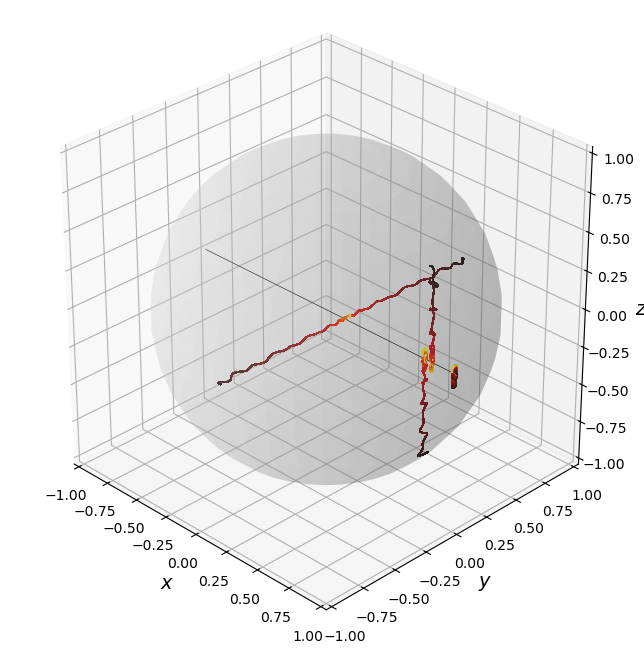

In [6]:
def U0 (t, omega = _omega, Omega = _Omega):
    """
    Interaction picture transformation
    """
    return (1j * Omega * np.sin(omega * t) / (2 * omega) * sigmax()).expm()

x = np.zeros((params1["Ntimesteps"], 5))
y = np.zeros((params1["Ntimesteps"], 5))
z = np.zeros((params1["Ntimesteps"], 5))

for i in range(params1["Ntimesteps"]):
    t = i * _tfPlotsBloch / params1["Ntimesteps"]
    UU = U0(t, omega=_omegaPlotsBloch, Omega=_OmegaPlotsBloch)
    rho_t = UU @ rho5[i] @ UU.dag()
    x[i,0] = (rho_t * sigmax()).tr().real
    y[i,0] = (rho_t * sigmay()).tr().real
    z[i,0] = (rho_t * sigmaz()).tr().real
    rho_t = UU @ rho4[i] @ UU.dag()
    x[i,1] = (rho_t * sigmax()).tr().real
    y[i,1] = (rho_t * sigmay()).tr().real
    z[i,1] = (rho_t * sigmaz()).tr().real
    rho_t = UU @ rho3[i] @ UU.dag()
    x[i,2] = (rho_t * sigmax()).tr().real
    y[i,2] = (rho_t * sigmay()).tr().real
    z[i,2] = (rho_t * sigmaz()).tr().real
    rho_t = UU @ rho2[i] @ UU.dag()
    x[i,3] = (rho_t * sigmax()).tr().real
    y[i,3] = (rho_t * sigmay()).tr().real
    z[i,3] = (rho_t * sigmaz()).tr().real
    rho_t = UU @ rho1[i] @ UU.dag()
    x[i,4] = (rho_t * sigmax()).tr().real
    y[i,4] = (rho_t * sigmay()).tr().real
    z[i,4] = (rho_t * sigmaz()).tr().real

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
xs = np.cos(u)*np.sin(v)
ys = np.sin(u)*np.sin(v)
zs = np.cos(v)
ax1.plot_surface(xs, ys, zs, color='lightgray', alpha=0.2, linewidth=0)

n_points = len(tlist)
cmap = cm.hot
norm = plt.Normalize(vmin=0, vmax=n_points - 1)
colors = cmap(norm(np.arange(n_points - 1)))


# Plot trajectories
for i in range(5):
    ax1.scatter(x[:,i],y[:,i],z[:,i], s=1, c=np.arange(len(x[:,i])), cmap=cmap, linewidths=0)
ax1.plot3D([-1, 1], [0, 0], [0, 0], color="black", linewidth=0.5)

# Formatting
ax1.set_box_aspect([1,1,1])
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_zlim([-1,1])
ax1.set_xlabel(r"$x$", fontsize=_fontsize)
ax1.set_ylabel(r"$y$", fontsize=_fontsize)
ax1.set_zlabel(r"$z$", fontsize=_fontsize)

ax1.view_init(elev=ax1.elev, azim=-45)

plt.savefig("trajs_same_params_no_U.png", dpi=300)
plt.show()

## Fig 2
Evolution of $Q$ at 3 snapshots for $\omega_r$ and $\omega_r\pm\Delta\omega$

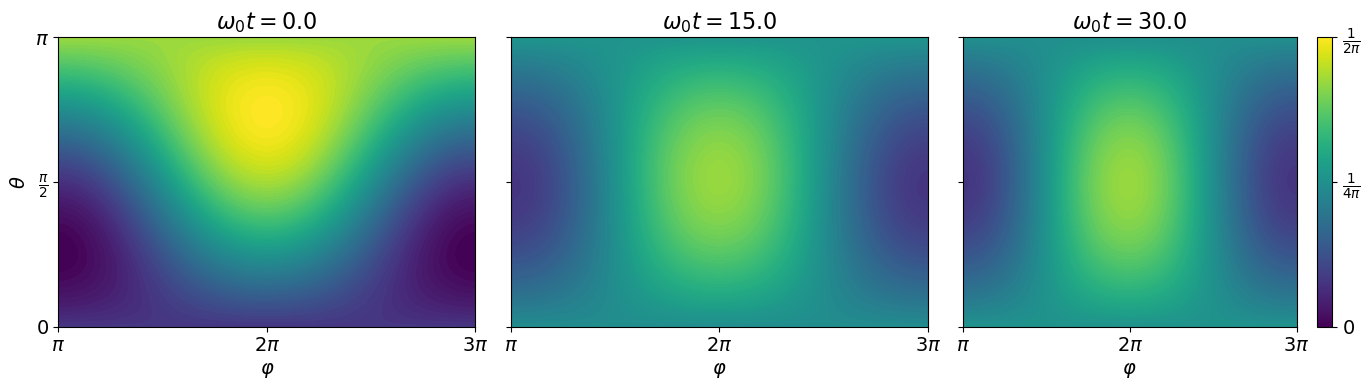

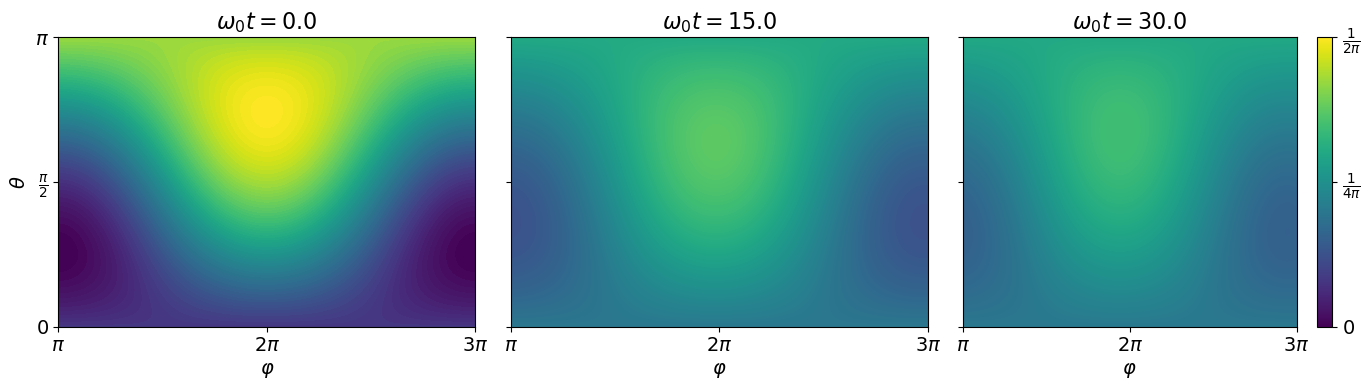

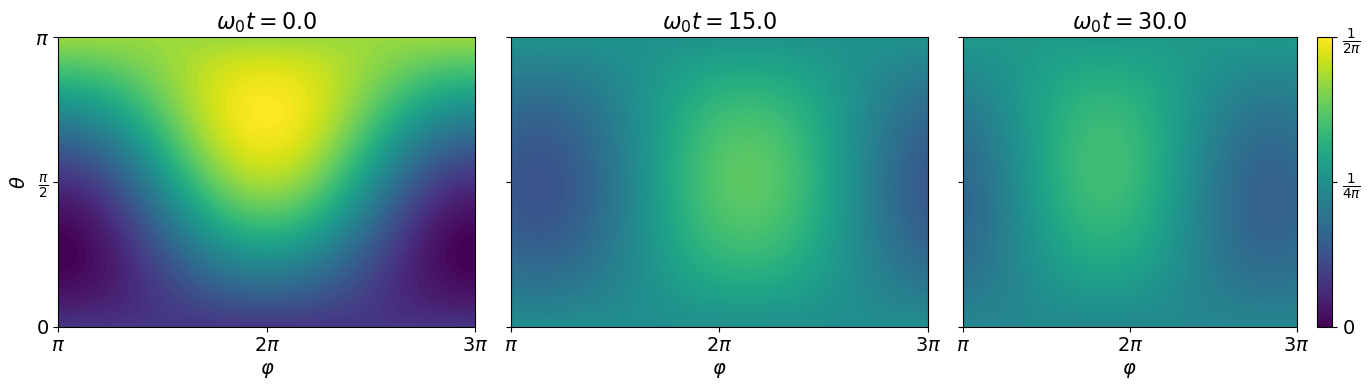

In [7]:
_figsize_Q = (14, 4)
_Nphi = 100
def plotQ_cart (rho, params, figsize = _figsize_Q, Nphi = _Nphi, string = ""):
    """
    Plots Q(theta, phi, t) at 3 equally spaced time points - cartesian coordinates
    """
    # Relevant timepoints
    relevant_t = np.linspace(0, params["tf"], 3)
    tlist = np.linspace(0, params["tf"], params["Ntimesteps"])
    idx_t = [np.argmin(np.abs(tlist - t)) for t in relevant_t]

    phis = np.linspace(0, 2 * np.pi, Nphi)
    thetas = np.linspace(0, np.pi, Nphi)
    Phi, Theta = np.meshgrid(phis, thetas)
    x = np.sin(Theta) * np.cos(Phi)
    y = np.sin(Theta) * np.sin(Phi)
    z = np.cos(Theta)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True, tight_layout=True)
    norm = mpl.colors.Normalize(vmin=_min_Q, vmax=_max_Q) # Setting the same color scale for all plots as the range of Q
    x_ticks = [0, np.pi, 2*np.pi]
    x_labels = [r"$\pi$", r"$2\pi$", r"$3\pi$"]
    y_ticks = [0, np.pi/2, np.pi]
    y_labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
    for j in range(3):
        t_idx = idx_t[j]

        rho_t = rho[t_idx]
        Z = np.array([[Q_func(t, p - np.pi, rho_t) for p in phis] for t in thetas])

        ax[j].contourf(Phi, Theta, Z, levels=100, cmap='viridis', norm=norm)
        ax[j].set_xticks(x_ticks)
        ax[j].set_xticklabels(x_labels, fontsize=_fontsize)
        ax[j].set_title(rf"$\omega_0 t = {relevant_t[j]:.1f}$", fontsize=_fontsize+2)
        ax[j].set_xlabel(r"$\varphi$", fontsize=_fontsize)
    ax[0].set_yticks(y_ticks)
    ax[0].set_yticklabels(y_labels, fontsize=_fontsize)
    ax[0].set_ylabel(r"$\theta$", fontsize=_fontsize)

    sm = mpl.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(_min_Q,_max_Q))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax[2])

    ticks = [0, 1/(4*np.pi), 1/(2*np.pi)]
    cbar.set_ticks(ticks)

    cbar.set_ticklabels([r"$0$", r"$\frac{1}{4\pi}$", r"$\frac{1}{2\pi}$"])

    cbar.ax.tick_params(labelsize=_fontsize)

    plt.tight_layout()
    plt.savefig("Q_p"+string+".png", dpi=300)

    plt.show()

    return

rho, params = evolve()
plotQ_cart(rho, params)
rho_m, params_m = evolve(omega=_omega-_domega)
plotQ_cart(rho_m, params_m, string="-")
rho_p, params_p = evolve(omega=_omega+_domega)
plotQ_cart(rho_p, params_p, string="+")

## Fig 3
Maximum of $Q$ as a function of $\theta$, $\varphi$ on the trajectory

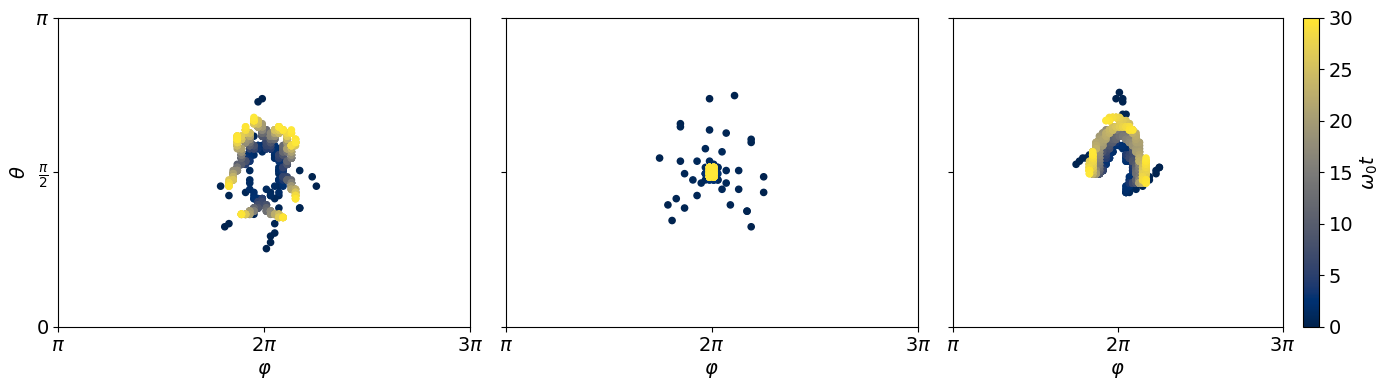

In [8]:
def plotMaxQ (rho, rho_p, rho_m, params, figsize = _figsize_Q, Nphi = _Nphi):
    """ 
    Plots the trajectory of maximum of Q on the theta-phi plane
    """
    tlist = np.linspace(0, params["tf"], params["Ntimesteps"])

    phis = np.linspace(0, 2 * np.pi, Nphi)
    thetas = np.linspace(0, np.pi, Nphi)

    theta_max = np.zeros(params["Ntimesteps"])
    phi_max = np.zeros(params["Ntimesteps"])
    theta_max_p = np.zeros(params["Ntimesteps"])
    phi_max_p = np.zeros(params["Ntimesteps"])
    theta_max_m = np.zeros(params["Ntimesteps"])
    phi_max_m = np.zeros(params["Ntimesteps"])
    Q_max = np.zeros(params["Ntimesteps"])
    Q_max_p = np.zeros(params["Ntimesteps"])
    Q_max_m = np.zeros(params["Ntimesteps"])

    for i in range(params["Ntimesteps"]):
        rho_t = rho[i]
        rho_p_t = rho_p[i]
        rho_m_t = rho_m[i]
        Z = np.array([[Q_func(t, p - np.pi, rho_t) for p in phis] for t in thetas])
        Z_p = np.array([[Q_func(t, p - np.pi, rho_p_t) for p in phis] for t in thetas])
        Z_m = np.array([[Q_func(t, p - np.pi, rho_m_t) for p in phis] for t in thetas])
        max_idx = np.unravel_index(np.argmax(Z), Z.shape)
        max_idx_p = np.unravel_index(np.argmax(Z_p), Z_p.shape)
        max_idx_m = np.unravel_index(np.argmax(Z_m), Z_m.shape)

        theta_max[i] = thetas[max_idx[0]]
        phi_max[i] = phis[max_idx[1]]
        theta_max_p[i] = thetas[max_idx_p[0]]
        phi_max_p[i] = phis[max_idx_p[1]]
        theta_max_m[i] = thetas[max_idx_m[0]]
        phi_max_m[i] = phis[max_idx_m[1]]
        Q_max[i] = Z[max_idx]
        Q_max_p[i] = Z_p[max_idx_p]
        Q_max_m[i] = Z_p[max_idx_p]
    
    fig, ax = plt.subplots(1, 3, figsize=figsize, tight_layout=True, sharex=True, sharey=True)
    ax[0].scatter(phi_max_m, theta_max_m, c=tlist, cmap='cividis', s=20)
    ax[1].scatter(phi_max, theta_max, c=tlist, cmap='cividis', s=20)
    p = ax[2].scatter(phi_max_p, theta_max_p, c=tlist, cmap='cividis', s=20)
    cbar = fig.colorbar(p, ax=ax[2])
    cbar.set_label(r'$\omega_0 t$', fontsize=_fontsize)
    cbar.ax.tick_params(labelsize=_fontsize)

    x_ticks = [0, np.pi, 2*np.pi]
    x_labels = [r"$\pi$", r"$2\pi$", r"$3\pi$"]
    y_ticks = [0, np.pi/2, np.pi]
    y_labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]
    for j in range(3):
        ax[j].set_xticks(x_ticks)
        ax[j].set_xticklabels(x_labels, fontsize=_fontsize)
        ax[j].set_xlabel(r"$\varphi$", fontsize=_fontsize)
    ax[0].set_ylabel(r"$\theta$", fontsize=_fontsize)
    ax[0].set_yticks(y_ticks)
    ax[0].set_yticklabels(y_labels, fontsize=_fontsize)
    
    plt.savefig("Q_max.png", dpi=300)
    plt.show()
    return
plotMaxQ(rho, rho_p, rho_m, params)

## Fig 4
$\max_\varphi S(\varphi, t)$ on the trajectories for the same 3 values of $\omega$

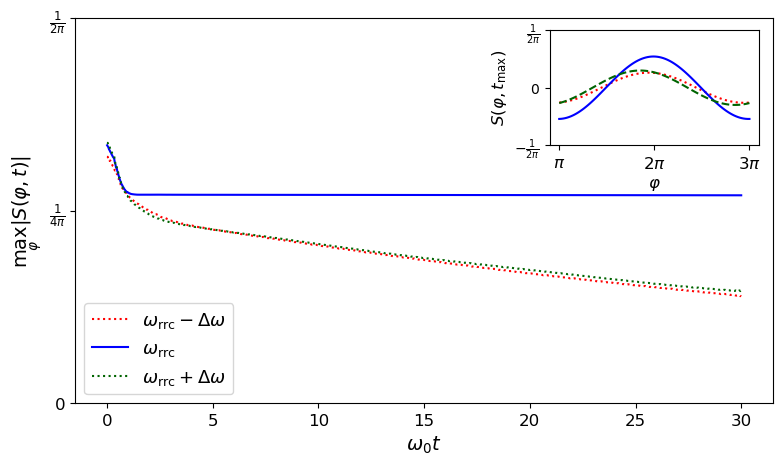

In [9]:
_N_avg = 20
_figsize_S_max = (9, 5)
def plotMaxS (rho, rho_p, rho_m, params, figsize = _figsize_S_max, Nphi = _Nphi, N_avg = _N_avg, insetSize = .3):
    """
    Plots max_phi S(phi, t)
    """
    # Relevant timepoints
    tlist = np.linspace(0, params["tf"], params["Ntimesteps"])

    phis = np.linspace(0, 2 * np.pi, Nphi)
    thetas = np.linspace(0, np.pi, Nphi)

    Smax = np.zeros(params["Ntimesteps"])
    Smax_p = np.zeros(params["Ntimesteps"])
    Smax_m = np.zeros(params["Ntimesteps"])

    for i in range(params["Ntimesteps"]):
        rho_t = rho[i]
        rho_p_t = rho_p[i]
        rho_m_t = rho_m[i]
        Z = np.array([[Q_func(t, p, rho_t) for p in phis] for t in thetas])
        Z_p = np.array([[Q_func(t, p, rho_p_t) for p in phis] for t in thetas])
        Z_m = np.array([[Q_func(t, p, rho_m_t) for p in phis] for t in thetas])

        mean_Q = np.trapz(Z * np.sin(thetas)[:, np.newaxis], thetas, axis=0) - (1 / (2 * np.pi))
        mean_Q_p = np.trapz(Z_p * np.sin(thetas)[:, np.newaxis], thetas, axis=0) - (1 / (2 * np.pi))
        mean_Q_m = np.trapz(Z_m * np.sin(thetas)[:, np.newaxis], thetas, axis=0) - (1 / (2 * np.pi))

        Smax[i] = np.max(abs(mean_Q))
        Smax_p[i] = np.max(abs(mean_Q_p))
        Smax_m[i] = np.max(abs(mean_Q_m))

    # Averaging S to smooth the plots
    half = N_avg // 2

    def moving_avg(arr, i, half):
        i_min = max(0, i - half)
        i_max = min(len(arr), i + half + 1)
        return np.mean(arr[i_min:i_max])

    Smax_avg = np.array([moving_avg(Smax, i, half) for i in range(params["Ntimesteps"])])
    Smax_p_avg = np.array([moving_avg(Smax_p, i, half) for i in range(params["Ntimesteps"])])
    Smax_m_avg = np.array([moving_avg(Smax_m, i, half) for i in range(params["Ntimesteps"])])

    # At the final timestep
    S = np.zeros(len(phis))
    S_p = np.zeros(len(phis))
    S_m = np.zeros(len(phis))

    rho_t = rho[-1]
    rho_p_t = rho_p[-1]
    rho_m_t = rho_m[-1]

    for j in range(len(phis)):
        Z = np.array([Q_func(t, phis[j] - np.pi, rho_t) for t in thetas])
        Z_p = np.array([Q_func(t, phis[j] - np.pi, rho_p_t) for t in thetas])
        Z_m = np.array([Q_func(t, phis[j] - np.pi, rho_m_t) for t in thetas])

        S[j] = np.trapz(Z * np.sin(thetas), thetas) - (1 / (2 * np.pi))
        S_p[j] = np.trapz(Z_p * np.sin(thetas), thetas) - (1 / (2 * np.pi))
        S_m[j] = np.trapz(Z_m * np.sin(thetas), thetas) - (1 / (2 * np.pi))

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    axx = ax.inset_axes([.98-insetSize, .97-insetSize, insetSize, insetSize])
    ax.plot(tlist, Smax_m_avg, s_omega_m, label=r'$\omega_{\text{rrc}} - \Delta\omega$', color=col_omega_m)
    ax.plot(tlist, Smax_avg, label=r'$\omega_{\text{rrc}}$', color=col_omega)
    ax.plot(tlist, Smax_p_avg, s_omega_m, label=r'$\omega_{\text{rrc}} + \Delta\omega$', color=col_omega_p)
    
    ax.set_xlabel(r"$\omega_0 t$", fontsize=_fontsize)
    ax.legend(loc='lower left', fontsize=_fontsize-1)

    y_ticks = [0, 1./(4*np.pi), 1./(2*np.pi)]
    y_labels = [r"$0$", r"$\frac{1}{4 \pi}$", r"$\frac{1}{2 \pi}$"]
    ax.set_ylabel(r"$\max_\varphi\vert S(\varphi,t)\vert$", fontsize=_fontsize)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=_fontsize)

    # Plots at final time
    axx.plot(phis, S_m, s_omega_m, color=col_omega_m)
    axx.plot(phis, S, color=col_omega)
    axx.plot(phis, S_p, s_omega_p, color=col_omega_p)

    axx.set_xlabel(r"$\varphi$", fontsize=_fontsize-2)
    axx.set_ylabel(r"$S(\varphi,t_{\text{max}})$", fontsize=_fontsize-2)

    x_ticks = [0, np.pi, 2*np.pi]
    x_labels = [r"$\pi$", r"$2 \pi$", r"$3 \pi$"]
    axx.set_xticks(x_ticks)
    axx.set_xticklabels(x_labels, fontsize=_fontsize-2)

    y_ticks = [0, 1/(2*np.pi), -1/(2*np.pi)]
    y_labels = [r"$0$", r"$\frac{1}{2 \pi}$", r"$-\frac{1}{2 \pi}$"]
    axx.set_yticks(y_ticks)
    axx.set_yticklabels(y_labels)
    ax.tick_params(axis='both', labelsize=_fontsize-2)

    plt.savefig("S_max.png", dpi=300)
    plt.show()

    return
plotMaxS(rho, rho_p, rho_m, params)

## Fig 5
$\max S$ as a function of $\omega$, $\Omega$

In [10]:
_omega_min = 10
_omega_max = 50
_Omega_min = 10
_Omega_max = 100
_Nomegas = 100
_N_avg = 30
_Delta_res_plots = .2
def plotMaxSOmega_Delta (omega_min = _omega_min, omega_max = _omega_max, Omega_min = _Omega_min, Omega_max = _Omega_max, Nomegas = _Nomegas, omega0 = _omega0, Delta = _Delta_res_plots, kappa = _kappa, tf = 40, Ntimesteps = _Ntimesteps, psi0 = _psi0, gamma = _gamma, lam = _lam, T = _T, Q = _Q, Nk = _Nk, max_depth_HEOM = _max_depth_HEOM, nsteps_HEOM = _nsteps_HEOM, Nphi = 50, figsize = (15,6), str_title = "", N_avg = _N_avg):
    """
    Plots max S as a function of omega and Omega
    """
    omegas = np.linspace(omega_min, omega_max, Nomegas)
    Omegas = np.linspace(Omega_min, Omega_max, Nomegas)

    phis = np.linspace(0, 2 * np.pi, Nphi)
    thetas = np.linspace(0, np.pi, Nphi)

    Smax = np.zeros((Nomegas, Nomegas))
    SmaxD = np.zeros((Nomegas, Nomegas))

    for i in range(Nomegas):
        for j in range(Nomegas):
            rho, _ = evolve(omega=omegas[i], Omega=Omegas[j], omega0=omega0, Delta=0, kappa=kappa, tf=tf, Ntimesteps=Ntimesteps, psi0=psi0, gamma=gamma, lam=lam, T=T, Q=Q, Nk=Nk, max_depth_HEOM=max_depth_HEOM, nsteps_HEOM=nsteps_HEOM)
            rhoD, _ = evolve(omega=omegas[i], Omega=Omegas[j], omega0=omega0, Delta=Delta, kappa=kappa, tf=tf, Ntimesteps=Ntimesteps, psi0=psi0, gamma=gamma, lam=lam, T=T, Q=Q, Nk=Nk, max_depth_HEOM=max_depth_HEOM, nsteps_HEOM=nsteps_HEOM)
            Zs = []
            ZsD = []
            for rho_t in rho[-N_avg:]:
                Z_t = np.array([[Q_func(t, p, rho_t) for p in phis] for t in thetas])
                Zs.append(Z_t)
            for rho_t in rhoD[-N_avg:]:
                Z_t = np.array([[Q_func(t, p, rho_t) for p in phis] for t in thetas])
                ZsD.append(Z_t)
            Z = sum(Zs) / len(Zs)
            ZD = sum(ZsD) / len(ZsD)
            mean_Q = np.trapz(Z * np.sin(thetas)[:, np.newaxis], thetas, axis=0) - (1 / (2 * np.pi))
            Smax[i,j] = min(np.max(abs(mean_Q)), 1./(2 * np.pi))
            mean_Q = np.trapz(ZD * np.sin(thetas)[:, np.newaxis], thetas, axis=0) - (1 / (2 * np.pi))
            SmaxD[i,j] = min(np.max(abs(mean_Q)), 1./(2 * np.pi))

    #fig, ax = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True, tight_layout=True)
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.1)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1], sharex=ax0, sharey=ax0)
    norm = mpl.colors.Normalize(vmin=0, vmax=_max_S) # Setting the same color scale for all plots as the range of Q
    omegas_mesh, Omega_mesh = np.meshgrid(omegas, Omegas, indexing='ij')
    
    ax0.contourf(Omega_mesh, omegas_mesh, Smax, levels=100, cmap='inferno', norm=norm)
    ax1.contourf(Omega_mesh, omegas_mesh, SmaxD, levels=100, cmap='inferno', norm=norm)

    cbar_ax = fig.add_subplot(gs[0, 2])

    sm = mpl.cm.ScalarMappable(cmap='inferno', norm=mpl.colors.Normalize(0,_max_S))
    sm.set_array([])
    #cbar = fig.colorbar(sm, ax=ax[1])
    cbar = fig.colorbar(sm, cax=cbar_ax)

    ticks = [0, 1/(4*np.pi), 1/(2*np.pi)]
    cbar.set_ticks(ticks)

    cbar.set_ticklabels([r"$0$", r"$\frac{1}{4\pi}$", r"$\frac{1}{2\pi}$"])

    cbar.ax.tick_params(labelsize=_fontsize)
    

    ax0.set_ylabel(r"$\omega/\omega_0$", fontsize=_fontsize)
    ax1.tick_params(axis='y', labelleft=False)
    for ax in [ax0, ax1]:
        ax.plot(2.4048 * omegas, omegas, color='white')
        ax.plot(5.52 * omegas, omegas, '--', color='white')
        ax.plot(8.65 * omegas, omegas, ':', color='white')
        ax.set_xlabel(r"$\Omega/\omega_0$", fontsize=_fontsize)
        ax.set_ylim(omega_min, omega_max)
        ax.set_xlim(Omega_min, Omega_max)

        ax.tick_params(axis='both', labelsize=_fontsize)

        ax.plot(_Omega, _omega, marker='o', color='white', markersize=5)
        ax.plot(_Omega, _omega - _domega, marker='x', color='white', markersize=5)
        ax.plot(_Omega, _omega + _domega, marker='x', color='white', markersize=5)
    
    plt.savefig("S_max_Omega_Delta.png", dpi=300)
    plt.show()

    return
plotMaxSOmega_Delta(Nomegas=100, omega_min=0, Omega_min=0)

NameError: name '_kappa' is not defined

## Fig 6
Dependence on bath parameters

In [ ]:
_lambda_min = 0.1
_lambda_max = 3
_gamma_min = 0.1
_gamma_max = 2.8
_Npoints = 100
_N_avg = 20
def plotMaxSBath_rel (lambda_min = _lambda_min, lambda_max = _lambda_max, gamma_min = _gamma_min, gamma_max = _gamma_max, Npoints = _Npoints, omega0 = _omega0, omega = _omega, Delta = _Delta, kappa = _kappa, tf = 40, Ntimesteps = _Ntimesteps, psi0 = _psi0, T = _T, Q = _Q, Nk = _Nk, max_depth_HEOM = _max_depth_HEOM, nsteps_HEOM = _nsteps_HEOM, Nphi = 50, figsize = (7,6), str_title = "", N_avg = _N_avg):
    """
    Plots max S as a function of lambda and gamma, relative
    """
    lambdas = np.linspace(lambda_min, lambda_max, Npoints)
    gammas = np.linspace(gamma_min, gamma_max, Npoints)

    phis = np.linspace(0, 2 * np.pi, Nphi)
    thetas = np.linspace(0, np.pi, Nphi)

    Smax = np.zeros((Npoints, Npoints))

    for i in range(Npoints):
        for j in range(Npoints):
            rho, _ = evolve(omega=_omega, Omega=_Omega, omega0=omega0, Delta=Delta, kappa=kappa, tf=tf, Ntimesteps=Ntimesteps, psi0=psi0, gamma=gammas[j], lam=lambdas[i], T=T, Q=Q, Nk=Nk, max_depth_HEOM=max_depth_HEOM, nsteps_HEOM=nsteps_HEOM)
            Zs = []
            for rho_t in rho[-N_avg:]:
                Z_t = np.array([[Q_func(t, p, rho_t) for p in phis] for t in thetas])
                Zs.append(Z_t)
            Z = sum(Zs) / len(Zs)
            mean_Q = np.trapz(Z * np.sin(thetas)[:, np.newaxis], thetas, axis=0) - (1 / (2 * np.pi))
            Smax[i,j] = min(np.max(abs(mean_Q)), 1./(2 * np.pi))

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    lambdas_mesh, gamma_mesh = np.meshgrid(lambdas, gammas, indexing='ij')
    f = ax.contourf(lambdas_mesh, gamma_mesh, Smax, levels=100, cmap='inferno')
    
    ax.set_xlabel(r"$\lambda/\omega_0$", fontsize=_fontsize)
    ax.set_ylabel(r"$\gamma/\omega_0$", fontsize=_fontsize)
    ax.set_xlim(lambda_min, lambda_max)
    ax.set_ylim(gamma_min, gamma_max)
    
    cbar = fig.colorbar(f, ax=ax)
    cbar.ax.tick_params(labelsize=_fontsize)

    ax.plot(_lam, _gamma, marker='o', color='black', markersize=5)

    plt.savefig("S_max_bath_rel.png", dpi=300)
    plt.show()

    return
plotMaxSBath_rel(Npoints=100)